# Calibration of the standard consumption-saving model

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Calibration of aggregate wealth](#toc2_)    
- 3. [Het-$\beta$ model](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Content:** Solves and simulates a simple consumption-saving model.

**Calibration:** Low and high liquid wealth calibrations.

**Model extension:** Discount factor heterogeneity

In [95]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

import scipy.optimize as opt
from ConSavModel import ConSavModelClass
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = ConSavModelClass()

## 2. <a id='toc2_'></a>[Calibration of aggregate wealth](#toc0_)

In [57]:
def calibrate_agg_wealth(x, model, wealth_to_income_target):
    
    # a. guess on beta 
    model.par.beta = x 

    # b. solve
    model.solve(do_print=False)

    # c. simulate
    model.simulate(do_print=False)

    # d. aggregate 
    A = np.sum(model.sim.D*model.sol.a)
    print(wealth_to_income_target - A/model.par.w)
   
    return wealth_to_income_target - A/model.par.w 

Calibrate model with high level of liquidity 

In [59]:
# Wealth target 
target_high_wealth = 4.1 * 4 # annual wealth to income ratio of 4.1, converted to quarterly frequency  
### ADD CODE HERE ###
opt_beta=opt.root_scalar(calibrate_agg_wealth, args=(model, target_high_wealth), bracket=[0.8, 0.989],method='bisect').root
# Add root finder (using the scipy package for instance) which findes the root of calibrate_agg_wealth() 
model.par.beta=opt_beta

16.4
-22.76643187945475
16.4
16.390519465321077
15.996962675119505
14.28776228982584
10.714925440748155
5.273555774159611
-1.4639179843116743
2.577406642515408
0.7827724289480216
-0.273659009428858
0.26978302090324746
0.002042736804085621
-0.1347894298296204
-0.06612092077251219
-0.031976722432602855
-0.014951451157486417
-0.006448072302891461
-0.002201700764917547
-7.924032395223435e-05
0.000981808642507076
0.0004512992546246153
0.00018603323302102126
5.339740472010135e-05
-1.2921217134476137e-05
2.0238152785623242e-05
3.6584818872142932e-06
-4.631364276974637e-06
-4.864405838134189e-07
1.5860209501283862e-06
5.497905277707105e-07
3.1675025269350954e-08
-2.2738244354059134e-07
-9.785337340417755e-08
-3.3089175843770136e-08
-7.067697538332141e-10
1.5484133086829388e-08
7.388681666498087e-09


MPCs 

In [60]:
def get_mpcs(model, do_print=False):
    c = model.sol.c 
    a = model.sol.a  
    par = model.par
    a_grid = par.a_grid 

    # Initialize and post return
    mpc = np.zeros_like(c)
    post_return = (1 + par.r) * a_grid

    # Calculate mpc for the inner part of the array as the slope of the consumption function 
    mpc[:,:, 1:] = np.diff(c, axis=2) / np.diff(post_return)

    # Handle boundary cases (first and last columns)
    mpc[:,:, 0] = (c[:,:, 1] - c[:,:, 0]) / (post_return[1] - post_return[0])
    mpc[:,:, -1] = (c[:,:, -1] - c[:,:, -2]) / (post_return[-1] - post_return[-2])

    # Set MPC to 1 if constrained 
    mpc[a == a_grid[0]] = 1

    MPC = np.sum(mpc*model.sim.D)
    if do_print: print(f'mean MPC: {MPC:6.3f}')

    return mpc

_ = get_mpcs(model, do_print=True)

mean MPC:  0.085


Plot MPCs and distribution 

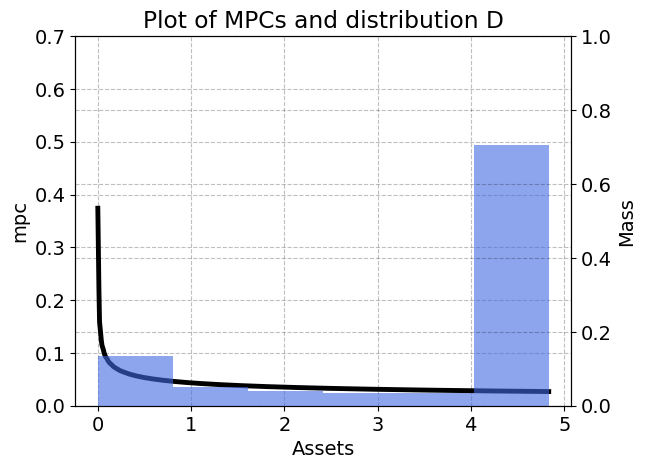

In [61]:
def mpc_plot(model, a_max=5., N_bins=6):

    # mpc 
    mpc = get_mpcs(model, do_print=False)

    # unload 
    par = model.par 
    D = model.sim.D 
    z_ergodic = par.z_ergodic
    a_grid = par.a_grid
    mpc_a = np.sum(mpc*z_ergodic[None,:,None], axis=(0,1))  # average over income in order to plot over assets only 
    D_a = np.sum(D, axis=(0,1))

    # plot settings for histogram 
    i_a_max = np.searchsorted(a_grid, a_max) - 1

    # bin distribution for better plot 
    from scipy.stats import binned_statistic
    D_A_binned, bin_edges, binnumber = binned_statistic(a_grid[:i_a_max], D_a[:i_a_max], statistic='sum', bins=N_bins)
    D_A_binned[-1] += np.sum(D_a[i_a_max:]) # add all mass above a_max to top bin 
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # get bin centers for plot 

    # Plot 
    fig, ax1 = plt.subplots()   

    # Plot mpc
    ax1.plot(a_grid[:i_a_max], mpc_a[:i_a_max], color='black', label='mpc', linewidth=3.5)
    ax1.set_xlabel('Assets')
    ax1.set_ylabel('mpc')
    ax1.tick_params(axis='y')
    ax1.set_ylim([0.,0.7])

    # Create a second y-axis for the histogram
    ax2 = ax1.twinx()
    ax2.bar(bin_centers, D_A_binned, width=bin_edges[1] - bin_edges[0], color='royalblue', alpha=0.6, label="Distribution")
    ax2.set_ylabel('Mass')
    ax2.tick_params(axis='y')
    ax2.set_ylim([0.,1.])

    plt.title("Plot of MPCs and distribution D")
    plt.show()

mpc_plot(model)

Calibrate model with low level of liquidity 

In [64]:
model_low_wealth = model.copy()
target_low_wealth = 0.5 * 4

### ADD CODE HERE ###
opt_beta_low=opt.root_scalar(calibrate_agg_wealth, args=(model_low_wealth, target_low_wealth), bracket=[0.5, 0.989],method='bisect').root
# Add root finder (using the scipy package for instance) which findes the root of calibrate_agg_wealth() 
model_low_wealth.par.beta=opt_beta_low
print(model_low_wealth.par.beta)

2.0
-37.16643187945475
2.0
2.0
2.0
1.8476845675953588
0.7204885367556022
-2.129918119797451
-0.2273230859191413
0.32094695482131774
0.06928255770213987
-0.07277158246505522
-0.0002957422438485402
0.03484731126272589
0.01736468145097847
0.00855680362856548
0.004136231845673688
0.0019216694436652304
0.000813311256041116
0.0002588710382354087
-1.8413965000352306e-05
0.00012023394770976914
5.09113411735207e-05
1.6249026153491997e-05
-1.0823848901608812e-06
7.58334174300046e-06
3.2504837113034313e-06
1.084050712529816e-06
8.33260793697832e-10
-5.40775717539077e-07
-2.699712404741206e-07
-1.3456895331387386e-07
-6.686786235832187e-08
-3.301728579430119e-08
-1.609204725028235e-08
-7.629393561359166e-09
-3.3980502855968098e-09
-1.2823964112840258e-09
-2.2458390702695397e-10
3.04337000045507e-10
0.976821759277871


Aggregate MPC 

In [65]:
_ = get_mpcs(model_low_wealth, do_print=True)

mean MPC:  0.342


plot mpcs 

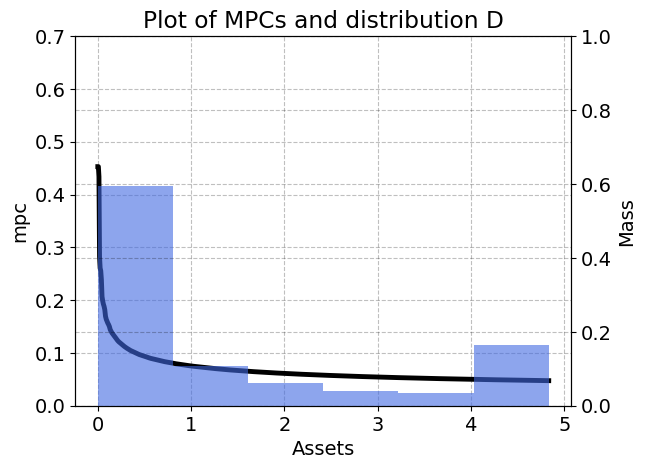

In [66]:
mpc_plot(model_low_wealth)

## 3. <a id='toc3_'></a>[Het-$\beta$ model](#toc0_)

Modify the household problem to allow for different discount factors across the population. In particular, the model is given by:
\begin{aligned}V\left(a_{t-1},z_{t},\beta'\right)= & \max_{c_{t}}u\left(c_{t}\right)+\beta'\mathbb{E}\left[V\left(a_{t},z_{t+1},\beta'\right)\right]\\
 & \text{ subject to }\\
 & c_{t}+a_{t}\leq a_{t-1}\left(1+r\right)+z_{t}\\
 & a_{t}\geq\underline{a}
\end{aligned}
where $\beta$ comes from an evenly spaced grid with $N_\beta$ points between $\beta-2\Delta,\beta+2\Delta$. 
Calibrate the model to match both a high level of liquidity and a high aggregate MPC using $(\beta, \Delta)$.

Note: You will need to update the code to set the beta grid (see next cell), and update the household problem (*solve_hh_backwards_egm*) appropriately.

In [67]:
model_hetbeta = ConSavModelClass()
model_hetbeta.par.Nbeta = 2 # Number of beta grid points 
model_hetbeta.allocate() # update size of beta grid 
model_hetbeta.par.beta_grid[:] = [0.8, 0.9] # set beta grid points

In [68]:
model_hetbeta.solve(do_print=True)

iteration    0 solved in 0.0 secs   [max abs. diff. 1.46e+02]
iteration    1 solved in 0.0 secs   [max abs. diff. 4.90e+01]
iteration    2 solved in 0.0 secs   [max abs. diff. 2.46e+01]
iteration    3 solved in 0.0 secs   [max abs. diff. 1.47e+01]
iteration    4 solved in 0.0 secs   [max abs. diff. 9.83e+00]
iteration    5 solved in 0.0 secs   [max abs. diff. 7.01e+00]
iteration    6 solved in 0.0 secs   [max abs. diff. 5.25e+00]
iteration    7 solved in 0.0 secs   [max abs. diff. 4.08e+00]
iteration    8 solved in 0.0 secs   [max abs. diff. 3.26e+00]
iteration    9 solved in 0.0 secs   [max abs. diff. 2.66e+00]
iteration  100 solved in 0.0 secs   [max abs. diff. 1.80e-04]
iteration  158 solved in 0.0 secs   [max abs. diff. 9.80e-09]
model solved in 0.1 secs


In [69]:
model_hetbeta.simulate(do_print=True)

model prepared for simulation in 0.0 secs
model simulated in 0.0 secs [114 iterations]


Check the distribution 

In [70]:
print('Mass of distribution (should be 1):', np.sum(model_hetbeta.sim.D))
assert np.isclose(np.sum(model_hetbeta.sim.D), 1.0 )

Mass of distribution (should be 1): 0.9999999994235917


Check how many households are in the beta states. If the distribution is uniform it should have an equal number of households across the beta grid

In [71]:
beta_mass = np.sum(model_hetbeta.sim.D,axis=(1,2)).round(2)
print(f'Mass of households across beta grid: {beta_mass}')
print(f'Should be {1/model_hetbeta.par.Nbeta}')

Mass of households across beta grid: [0.5 0.5]
Should be 0.5


Next, calibrate the model to both feature a high MPC and a high level of wealth

In [111]:
# Wealth target 
target_high_wealth = 4.1 * 4 # annual wealth to income ratio of 4.1, converted to quarterly frequency  
target_mpc=0.342

def calibrate_agg_wealth_and_mpc(x, model, wealth_to_income_target, mpc_target):
    beta, Delta = x
    # a. guess on beta 
    model.par.beta = beta 
    model.par.beta_grid[:] = [beta-2*Delta, beta+2*Delta] # set beta grid points

    # b. solve
    model.solve(do_print=False)

    # c. simulate
    model.simulate(do_print=False)

    # d. aggregate 
    A = np.sum(model.sim.D*model.sol.a)

    mpc = np.sum(get_mpcs(model, do_print=False)*model.sim.D)

    print(wealth_to_income_target - A/model.par.w, mpc - mpc_target)
   
    return 0.5*(wealth_to_income_target - A/model.par.w)**2+0.5*(mpc - mpc_target)**2

guess=[0.935, 0.02]
calibrate_agg_wealth_and_mpc(guess, model_hetbeta, target_high_wealth, target_mpc)
bounds = [(0.94, 0.985), (0.001, 0.1)]
opt_beta_het=opt.minimize(calibrate_agg_wealth_and_mpc, guess, args=(model_hetbeta, target_high_wealth, target_mpc), bounds=bounds, method='Nelder-Mead').x

16.397737094540744 0.6434599881113592
16.39309388626776 0.6386505032148309


C:\Users\krist\AppData\Local\Temp\ipykernel_16040\1572226994.py:29: OptimizeWarning: Initial guess is not within the specified bounds
  opt_beta_het=opt.minimize(calibrate_agg_wealth_and_mpc, guess, args=(model_hetbeta, target_high_wealth, target_mpc), bounds=bounds, method='Nelder-Mead').x


10.817726234164741 -0.14527031260811388
16.39309388626776 0.6386505032148309
10.81772623416462 -0.14527031260811615
7.864966564208087 -0.19530866398550964
7.864966564208087 -0.19530866398550964
7.864966564208087 -0.19530866398550964
7.864966564208087 -0.19530866398550964
7.864966564208087 -0.19530866398550964
7.864966564208087 -0.19530866398550964
7.864966564208087 -0.19530866398550964
7.864966564208087 -0.19530866398550964
7.864966564208087 -0.19530866398550964


Traceback (most recent call last):
  File "c:\Users\krist\OneDrive - Københavns Universitet\11. semester\Heterogenous agent models\AdvMacroHet_fork\02-Consumption-Saving\ConSavModel.py", line 140, in solve
    solve_hh_backwards_egm(par,c_plus,sol.c,sol.a)
KeyboardInterrupt


KeyboardInterrupt: 

Check MPC

In [ ]:
_ = get_mpcs(model_hetbeta, do_print=True)

Plot MPCs  

In [ ]:
mpc_plot(model_hetbeta)

*Final question*. Try changing the mass of agents across the beta distribution. Set Nbeta=3 and assume that the mass is distributed as [0.2, 0.6, 0.2] across the beta grid. What part of the code do you have to modify?